Загрузка данных BTC-USD с 2020-01-01 по 2023-12-31...
Форма X: (1405, 30, 4), форма y: (1405, 5)


Обучение:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100 | Train Loss: 0.003286 | Val Loss: 0.000849


Обучение:  12%|█▏        | 12/100 [00:01<00:07, 11.10it/s]

Epoch 11/100 | Train Loss: 0.001669 | Val Loss: 0.000685


Обучение:  18%|█▊        | 18/100 [00:01<00:07, 10.49it/s]


Ранняя остановка на эпохе 19


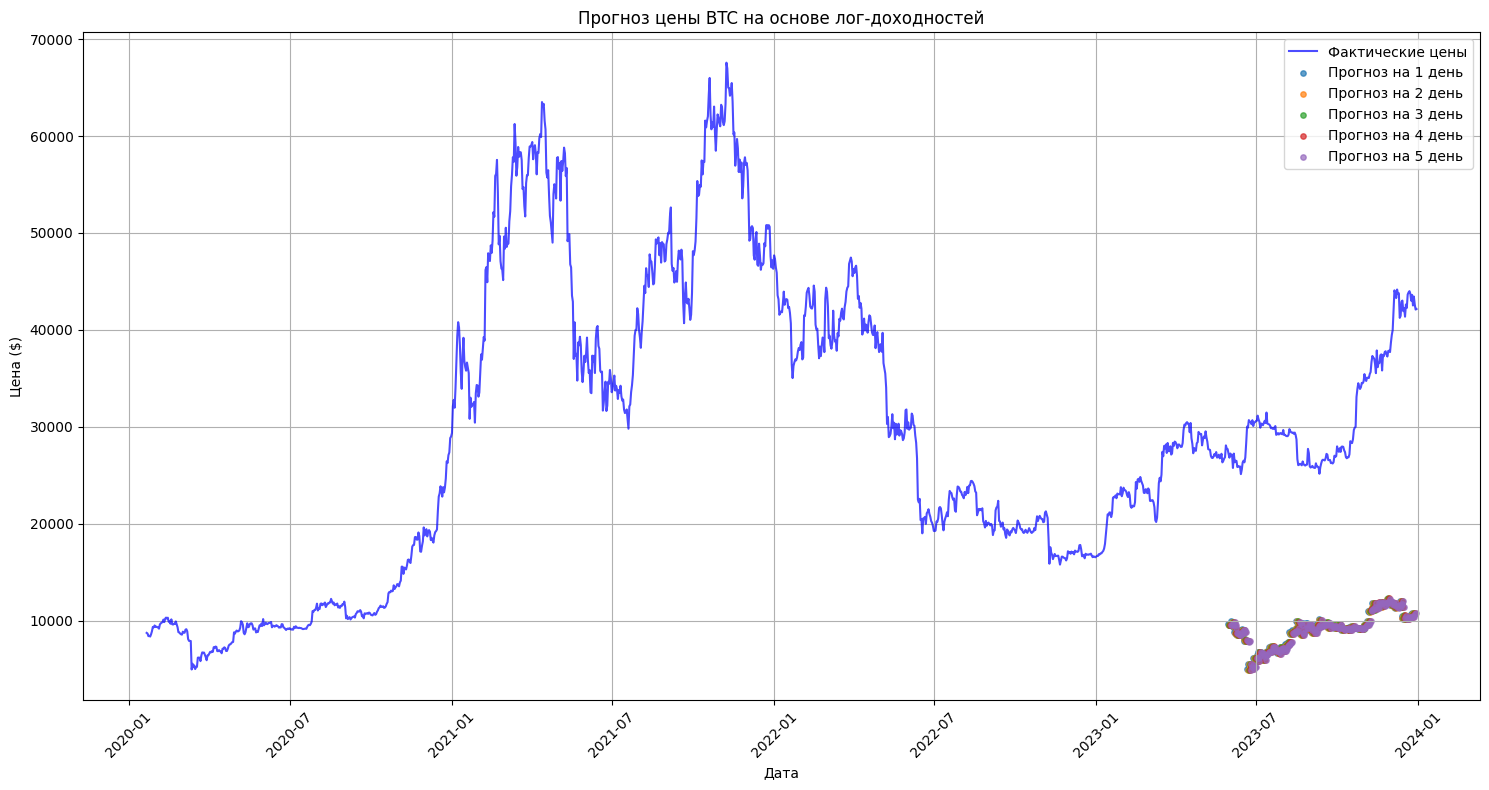


Средняя абсолютная ошибка по дням прогноза ($):
Horizon
1    [205.26812652152302]
2     [292.2431210036651]
3     [380.5149150599088]
4     [439.9502525100191]
5    [492.64848384989335]
dtype: object


<ipython-input-3-53486aaf451e>:165: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_preds = results_df.groupby('Horizon').apply(


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import timedelta
import os

# Константы
SEQ_LENGTH = 30
PRED_LENGTH = 5
TEST_SIZE = 0.15
VAL_SIZE = 0.15
MODEL_PATH = 'pa_rnn_crypto_returns.pth'

def load_crypto_data(ticker='BTC-USD', start='2020-01-01', end='2024-12-31'):
    print(f"Загрузка данных {ticker} с {start} по {end}...")
    data = yf.download(ticker, start=start, end=end, progress=False)

    # Лог-доходности и индикаторы
    data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
    data['SMA_20_Returns'] = data['Log_Returns'].rolling(20).mean()
    data['EMA_10_Returns'] = data['Log_Returns'].ewm(span=10, adjust=False).mean()
    data['Volatility'] = data['Log_Returns'].rolling(20).std()
    data = data.dropna()

    features = data[['Log_Returns', 'SMA_20_Returns', 'EMA_10_Returns', 'Volatility']]
    return features.values, data

def create_sequences(data, dates, seq_length=SEQ_LENGTH, pred_length=PRED_LENGTH):
    X, y, X_dates = [], [], []
    for i in range(len(data)-seq_length-pred_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+pred_length, 0])  # Прогноз Log_Returns
        X_dates.append(dates[i+seq_length])
    return np.array(X), np.array(y), np.array(X_dates)

class Hybride_BTC_Predictor(nn.Module):
    def __init__(self, input_size=9, hidden_size=128, num_layers=2, pred_length=PRED_LENGTH):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2 if num_layers > 1 else 0)
        self.temp_attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size), nn.Tanh(),
            nn.Linear(hidden_size, 1), nn.Softmax(dim=1))
        self.feat_attention = nn.Sequential(
            nn.Linear(SEQ_LENGTH, SEQ_LENGTH), nn.Tanh(),
            nn.Linear(SEQ_LENGTH, 1), nn.Softmax(dim=2))
        self.combine = nn.Sequential(
            nn.Linear(hidden_size + input_size, hidden_size),
            nn.ReLU(), nn.Dropout(0.3))
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, pred_length))

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        temp_attn = self.temp_attention(lstm_out)
        temp_context = torch.sum(temp_attn * lstm_out, dim=1)

        feat_attn = self.feat_attention(x.transpose(1, 2))
        feat_context = torch.sum(feat_attn * x.transpose(1, 2), dim=2).squeeze()

        combined = torch.cat([temp_context, feat_context], dim=1)
        combined = self.combine(combined)
        return self.fc(combined)

def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=64, patience=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train)),
                            batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val)),
                          batch_size=batch_size)

    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    best_loss = float('inf')
    for epoch in tqdm(range(epochs), desc="Обучение"):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch.to(device))
            loss = criterion(outputs, y_batch.to(device))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                outputs = model(X_val_batch.to(device))
                val_loss += criterion(outputs, y_val_batch.to(device)).item()

        val_loss /= len(val_loader)
        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Ранняя остановка на эпохе {epoch+1}")
                break

        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_loader):.6f} | Val Loss: {val_loss:.6f}")

    model.load_state_dict(torch.load('best_model.pth'))
    return model

def main():
    # Загрузка и подготовка данных
    data_scaled, original_data = load_crypto_data()
    dates = original_data.index

    # Создание последовательностей
    X, y, X_dates = create_sequences(data_scaled, dates)

    # Проверка размерностей
    print(f"Форма X: {X.shape}, форма y: {y.shape}")  # Должно быть (n_samples, SEQ_LENGTH, n_features)

    # Разделение данных
    test_size = int(len(X) * TEST_SIZE)
    val_size = int(len(X) * VAL_SIZE)
    train_size = len(X) - val_size - test_size

    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
    X_test, y_test, test_dates = X[train_size+val_size:], y[train_size+val_size:], X_dates[train_size+val_size:]

    # Инициализация модели с правильным input_size
    input_size = X_train.shape[2] if len(X_train.shape) > 2 else 1  # Защита от 2D-массивов
    model = Hybrid_BTC_Predictor(input_size=input_size)

    # Обучение
    if os.path.exists(MODEL_PATH):
        print(f"Загрузка модели из {MODEL_PATH}")
        model = torch.load(MODEL_PATH)
    else:
        model = train_model(model, X_train, y_train, X_val, y_val)
        torch.save(model, MODEL_PATH)

    # Прогнозирование
    model.eval()
    with torch.no_grad():
        test_input = torch.FloatTensor(X_test).to(next(model.parameters()).device)
        pred_returns = model(test_input).cpu().numpy()

    # Прогнозирование и визуализация
    results_df = plot_predictions(model, X_test, y_test, test_dates, original_data)

    # Оценка точности в абсолютных ценах
    test_preds = results_df.groupby('Horizon').apply(
        lambda x: np.mean(np.abs(x['Predicted'] - x['Actual']))
    )
    print("\nСредняя абсолютная ошибка по дням прогноза ($):")
    print(test_preds)


if __name__ == "__main__":
    main()

Загрузка данных BTC-USD с 2020-01-01 по 2023-12-31...
Форма X: (1405, 30, 4), форма y: (1405, 5)


Обучение:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100 | Train Loss: 0.002012 | Val Loss: 0.000756


Обучение:  12%|█▏        | 12/100 [00:01<00:08, 10.94it/s]

Epoch 11/100 | Train Loss: 0.001563 | Val Loss: 0.000687


Обучение:  22%|██▏       | 22/100 [00:02<00:07, 10.93it/s]

Epoch 21/100 | Train Loss: 0.001565 | Val Loss: 0.000689


Обучение:  31%|███       | 31/100 [00:02<00:06, 10.68it/s]


Epoch 31/100 | Train Loss: 0.001533 | Val Loss: 0.000687
Ранняя остановка на эпохе 32

Прогнозы цен по датам:
     Дата       |  Горизонт (дн)  |  Реальная цена ($)   |     Прогноз ($)      |   Ошибка ($)   
--------------------------------------------------------------------------------
  31 May 2023   |        1        |       27219.66       |       27725.96       |     506.31     
 01 June 2023   |        2        |       26819.97       |       27794.54       |     974.57     
 02 June 2023   |        3        |       27249.59       |       27813.68       |     564.09     
 03 June 2023   |        4        |       27075.13       |       27878.24       |     803.11     
 04 June 2023   |        5        |       27119.07       |       27938.39       |     819.32     
 01 June 2023   |        1        |       26819.97       |       27244.07       |     424.10     
 02 June 2023   |        2        |       27249.59       |       27312.97       |      63.38     
 03 June 2023   |        

<ipython-input-6-2a9420fc9ad0>:187: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  actual = float(row['Actual'])
<ipython-input-6-2a9420fc9ad0>:188: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  predicted = float(row['Predicted'])
<ipython-input-6-2a9420fc9ad0>:189: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  abs_error = float(row['AbsError'])
<ipython-input-6-2a9420fc9ad0>:193: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  error_by_horizon = results_df.groupby('Horizon')['AbsError'].mean()
<ipython-input-6-2a9420fc9ad0>:204: FutureWarning: Calling float on a single element Series is deprecated a

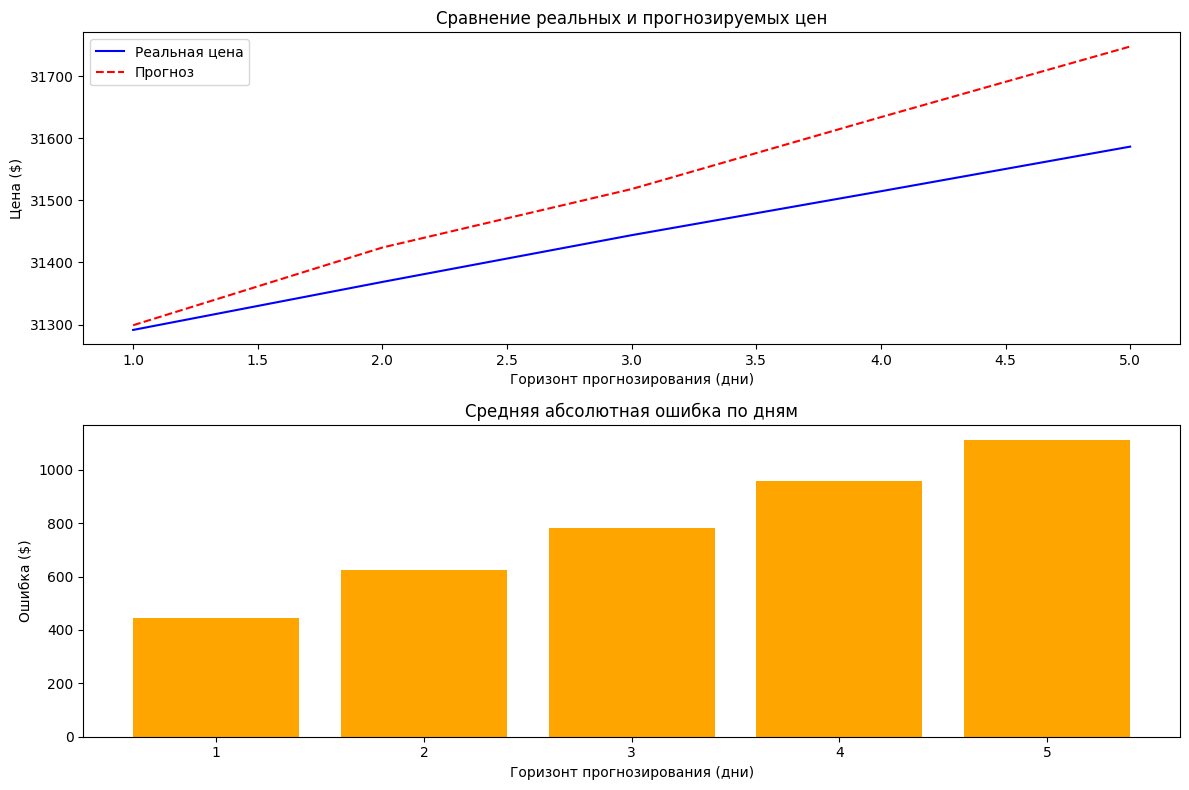


Результаты сохранены в файл crypto_prediction_results.csv и график в crypto_prediction_results.png


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import timedelta
import os

# Константы
SEQ_LENGTH = 30
PRED_LENGTH = 5
TEST_SIZE = 0.15
VAL_SIZE = 0.15
#MODEL_PATH = 'pa_rnn_crypto_returns.pth'

def load_crypto_data(ticker='BTC-USD', start='2020-01-01', end='2023-12-31'):
    print(f"Загрузка данных {ticker} с {start} по {end}...")
    data = yf.download(ticker, start=start, end=end, progress=False)

    # Лог-доходности и индикаторы
    data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
    data['SMA_20_Returns'] = data['Log_Returns'].rolling(20).mean()
    data['EMA_10_Returns'] = data['Log_Returns'].ewm(span=10, adjust=False).mean()
    data['Volatility'] = data['Log_Returns'].rolling(20).std()
    data = data.dropna()

    features = data[['Log_Returns', 'SMA_20_Returns', 'EMA_10_Returns', 'Volatility']]
    return features.values, data

def create_sequences(data, dates, seq_length=SEQ_LENGTH, pred_length=PRED_LENGTH):
    X, y, X_dates = [], [], []
    for i in range(len(data)-seq_length-pred_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+pred_length, 0])  # Прогноз Log_Returns
        X_dates.append(dates[i+seq_length])
    return np.array(X), np.array(y), np.array(X_dates)

class PARNNPredictor(nn.Module):
    def __init__(self, input_size=4, hidden_size=128, num_layers=2, pred_length=PRED_LENGTH):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2 if num_layers > 1 else 0)
        self.temp_attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size), nn.Tanh(),
            nn.Linear(hidden_size, 1), nn.Softmax(dim=1))
        self.feat_attention = nn.Sequential(
            nn.Linear(SEQ_LENGTH, SEQ_LENGTH), nn.Tanh(),
            nn.Linear(SEQ_LENGTH, 1), nn.Softmax(dim=2))
        self.combine = nn.Sequential(
            nn.Linear(hidden_size + input_size, hidden_size),
            nn.ReLU(), nn.Dropout(0.3))
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, pred_length))

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        temp_attn = self.temp_attention(lstm_out)
        temp_context = torch.sum(temp_attn * lstm_out, dim=1)

        feat_attn = self.feat_attention(x.transpose(1, 2))
        feat_context = torch.sum(feat_attn * x.transpose(1, 2), dim=2).squeeze()

        combined = torch.cat([temp_context, feat_context], dim=1)
        combined = self.combine(combined)
        return self.fc(combined)

def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=64, patience=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train)),
                            batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val)),
                          batch_size=batch_size)

    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    best_loss = float('inf')
    for epoch in tqdm(range(epochs), desc="Обучение"):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch.to(device))
            loss = criterion(outputs, y_batch.to(device))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                outputs = model(X_val_batch.to(device))
                val_loss += criterion(outputs, y_val_batch.to(device)).item()

        val_loss /= len(val_loader)
        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Ранняя остановка на эпохе {epoch+1}")
                break

        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_loader):.6f} | Val Loss: {val_loss:.6f}")

    model.load_state_dict(torch.load('best_model.pth'))
    return model

def plot_predictions(model, X_test, y_test, test_dates, original_data):
    """
    Выполняет прогнозирование и создает наглядное отображение результатов по датам
    с указанием реальной цены, предсказанной цены и абсолютной ошибки.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    with torch.no_grad():
        test_input = torch.FloatTensor(X_test).to(device)
        pred_returns = model(test_input).cpu().numpy()

    # Создаем DataFrame для результатов
    results = []

    for i, (start_date, y_true, y_pred) in enumerate(zip(test_dates, y_test, pred_returns)):
        # Преобразуем лог-доходность в цены
        actual_prices = []
        predicted_prices = []

        # Получаем начальную цену для этой последовательности
        start_price = original_data.loc[start_date, 'Close']

        # Вычисляем цены для каждого дня в горизонте прогнозирования
        for day in range(PRED_LENGTH):
            date = start_date + timedelta(days=day+1)
            # Если дата не рабочий день, найдем следующий рабочий день
            while date not in original_data.index and date <= original_data.index[-1]:
                date += timedelta(days=1)

            if date in original_data.index:
                actual_price = original_data.loc[date, 'Close']
                # Вычисляем предсказанную цену на основе прогнозируемых доходностей
                if day == 0:
                    predicted_price = start_price * np.exp(y_pred[day])
                else:
                    predicted_price = predicted_prices[-1] * np.exp(y_pred[day])

                # Абсолютная ошибка
                abs_error = abs(actual_price - predicted_price)

                results.append({
                    'Date': date.strftime('%d %B %Y'),
                    'Horizon': day + 1,
                    'Actual': actual_price,
                    'Predicted': predicted_price,
                    'AbsError': abs_error
                })

                actual_prices.append(actual_price)
                predicted_prices.append(predicted_price)

    # Создаем DataFrame с результатами
    results_df = pd.DataFrame(results)

    # Выводим таблицу с результатами
    print("\nПрогнозы цен по датам:")
    print("=" * 80)
    print(f"{'Дата':^15} | {'Горизонт (дн)':^15} | {'Реальная цена ($)':^20} | {'Прогноз ($)':^20} | {'Ошибка ($)':^15}")
    print("-" * 80)

    for _, row in results_df.iterrows():
        date = row['Date']
        horizon = int(row['Horizon'])
        actual = float(row['Actual'])
        predicted = float(row['Predicted'])
        abs_error = float(row['AbsError'])
        print(f"{date:^15} | {horizon:^15} | {actual:^20.2f} | {predicted:^20.2f} | {abs_error:^15.2f}")

    # Группируем и выводим среднюю ошибку по дням прогноза
    error_by_horizon = results_df.groupby('Horizon')['AbsError'].mean()

    print("\nСредняя абсолютная ошибка по дням прогноза ($):")
    print("-" * 50)
    for horizon, error in error_by_horizon.items():
        print(f"День {horizon}: ${error:.2f}")

    # Визуализация результатов
    plt.figure(figsize=(12, 8))

    # Сгруппированные по дням и усредненные данные для графика
    avg_results = results_df.groupby('Horizon')[['Actual', 'Predicted']].mean()

    plt.subplot(2, 1, 1)
    plt.plot(avg_results.index, avg_results['Actual'], 'b-', label='Реальная цена')
    plt.plot(avg_results.index, avg_results['Predicted'], 'r--', label='Прогноз')
    plt.title('Сравнение реальных и прогнозируемых цен')
    plt.xlabel('Горизонт прогнозирования (дни)')
    plt.ylabel('Цена ($)')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.bar(error_by_horizon.index, error_by_horizon.values, color='orange')
    plt.title('Средняя абсолютная ошибка по дням')
    plt.xlabel('Горизонт прогнозирования (дни)')
    plt.ylabel('Ошибка ($)')

    plt.tight_layout()
    plt.savefig('crypto_prediction_results.png')
    plt.show()

    return results_df

def main():
    # Загрузка и подготовка данных
    data_scaled, original_data = load_crypto_data()
    dates = original_data.index

    # Создание последовательностей
    X, y, X_dates = create_sequences(data_scaled, dates)

    # Проверка размерностей
    print(f"Форма X: {X.shape}, форма y: {y.shape}")  # Должно быть (n_samples, SEQ_LENGTH, n_features)

    # Разделение данных
    test_size = int(len(X) * TEST_SIZE)
    val_size = int(len(X) * VAL_SIZE)
    train_size = len(X) - val_size - test_size

    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
    X_test, y_test, test_dates = X[train_size+val_size:], y[train_size+val_size:], X_dates[train_size+val_size:]

    # Инициализация модели с правильным input_size
    input_size = X_train.shape[2] if len(X_train.shape) > 2 else 1  # Защита от 2D-массивов
    model = PARNNPredictor(input_size=input_size)

    # Обучение
    if os.path.exists(MODEL_PATH):
        print(f"Загрузка модели из {MODEL_PATH}")
        model = torch.load(MODEL_PATH)
    else:
        model = train_model(model, X_train, y_train, X_val, y_val)
        torch.save(model, MODEL_PATH)

    # Прогнозирование и визуализация
    results_df = plot_predictions(model, X_test, y_test, test_dates, original_data)

    # Опционально: сохранение результатов в CSV
    results_df.to_csv('crypto_prediction_results.csv', index=False)
    print(f"\nРезультаты сохранены в файл crypto_prediction_results.csv и график в crypto_prediction_results.png")


if __name__ == "__main__":
    main()

Загрузка данных BTC-USD с 2020-01-01 по 2023-12-31...
Форма данных: X=(1405, 30, 4), y=(1405, 5)
Train: (985, 30, 4), Val: (210, 30, 4), Test: (210, 30, 4)
Обучение новой модели...
Epoch 1/150 | Train Loss: 0.0042 | Val MAE: 0.0214
Epoch 2/150 | Train Loss: 0.0042 | Val MAE: 0.0197
Epoch 3/150 | Train Loss: 0.0042 | Val MAE: 0.0203
Epoch 4/150 | Train Loss: 0.0042 | Val MAE: 0.0204
Epoch 5/150 | Train Loss: 0.0043 | Val MAE: 0.0218
Epoch 6/150 | Train Loss: 0.0042 | Val MAE: 0.0203
Epoch 7/150 | Train Loss: 0.0042 | Val MAE: 0.0196
Epoch 8/150 | Train Loss: 0.0043 | Val MAE: 0.0209
Epoch 9/150 | Train Loss: 0.0043 | Val MAE: 0.0216
Epoch 10/150 | Train Loss: 0.0043 | Val MAE: 0.0205
Epoch 11/150 | Train Loss: 0.0044 | Val MAE: 0.0221
Epoch 12/150 | Train Loss: 0.0042 | Val MAE: 0.0202
Epoch 13/150 | Train Loss: 0.0042 | Val MAE: 0.0198
Epoch 14/150 | Train Loss: 0.0043 | Val MAE: 0.0210
Epoch 15/150 | Train Loss: 0.0043 | Val MAE: 0.0201
Epoch 16/150 | Train Loss: 0.0042 | Val MAE: 0.0

<ipython-input-6-5c7d00d37166>:301: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mae_by_horizon = results_df.groupby('Horizon')['AbsError'].mean()
<ipython-input-6-5c7d00d37166>:305: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mape_by_horizon = results_df.groupby('Horizon')['PctError'].mean()
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)
<ipython-input-6-5c7d00d37166

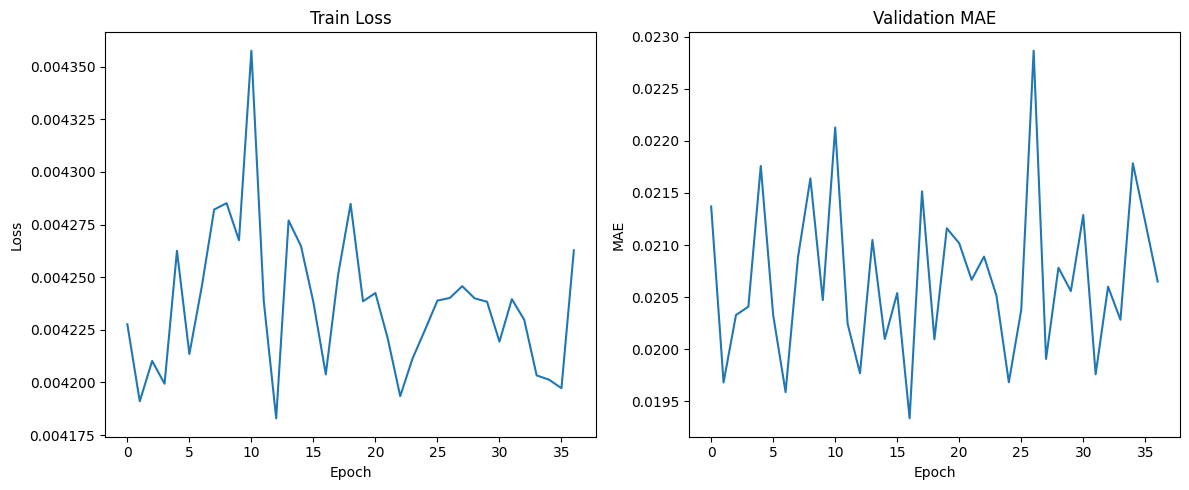

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


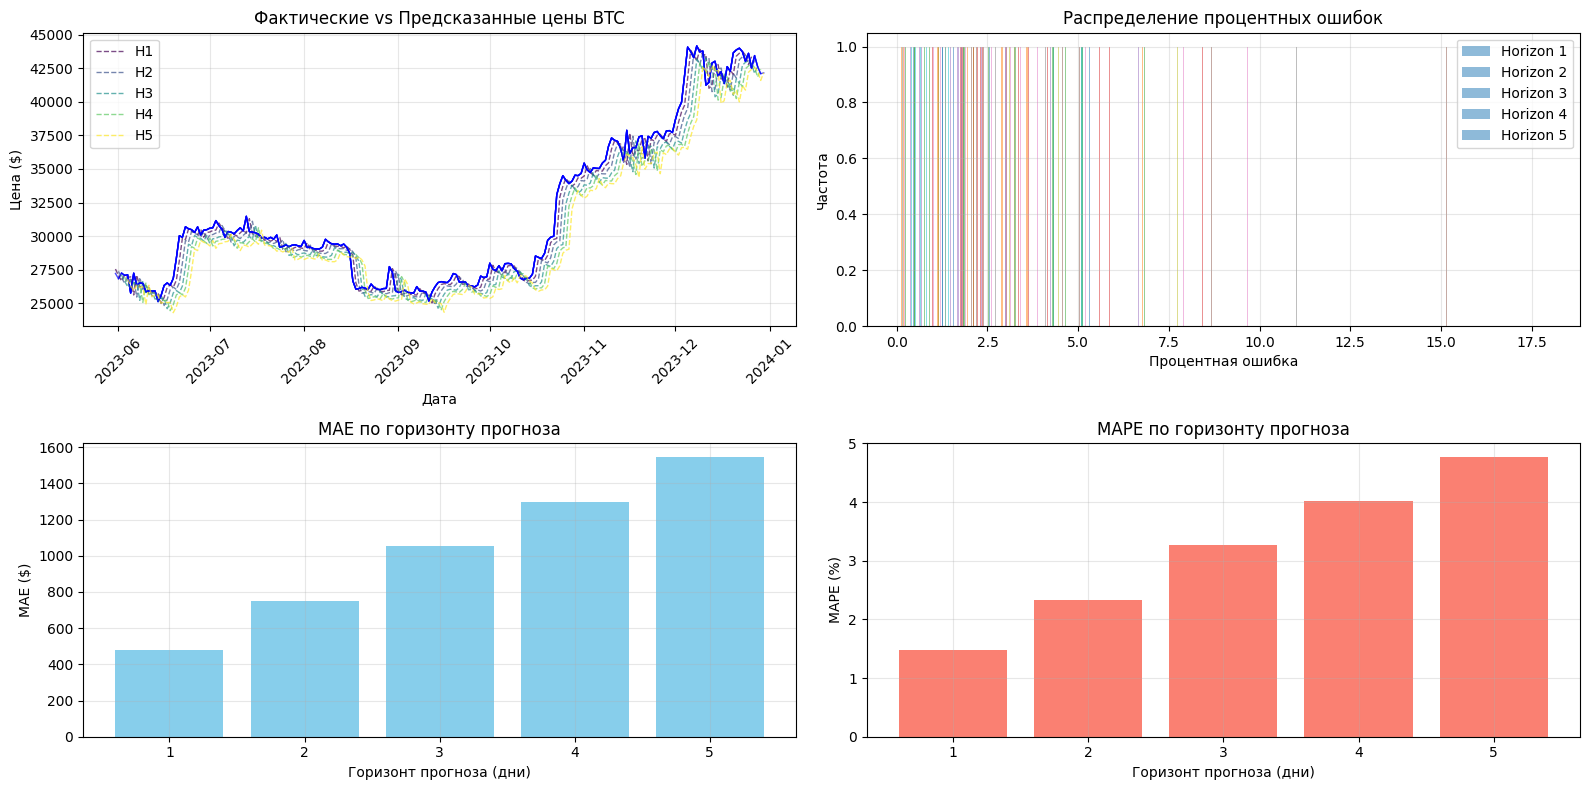


Сводные результаты прогнозирования:
Средняя абсолютная ошибка: $1024.89
Средняя процентная ошибка: 3.17%


<ipython-input-6-5c7d00d37166>:406: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"Средняя абсолютная ошибка: ${results_df['AbsError'].mean():.2f}")
<ipython-input-6-5c7d00d37166>:407: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"Средняя процентная ошибка: {results_df['PctError'].mean():.2f}%")


TypeError: Cannot convert [Ticker
 BTC-USD    326.56656
 dtype: float64       Ticker
                      BTC-USD    555.48643
                      dtype: float64       Ticker
                                           BTC-USD    133.478768
                                           dtype: float64        ...
 Ticker
 BTC-USD    64.749388
 dtype: float64       Ticker
                      BTC-USD    332.044801
                      dtype: float64        Ticker
                                            BTC-USD    15.664965
                                            dtype: float64      ] to numeric

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import timedelta
import os

# Константы
SEQ_LENGTH = 30
PRED_LENGTH = 5
TEST_SIZE = 0.15
VAL_SIZE = 0.15
MODEL_PATH = 'pa_rnn_crypto_returns.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_crypto_data(ticker='BTC-USD', start='2020-01-01', end='2023-12-31'):
    print(f"Загрузка данных {ticker} с {start} по {end}...")
    data = yf.download(ticker, start=start, end=end, progress=False)

    # Фичи и лог-доходности
    data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
    data['SMA_20_Returns'] = data['Log_Returns'].rolling(20).mean()
    data['EMA_10_Returns'] = data['Log_Returns'].ewm(span=10, adjust=False).mean()
    data['Volatility'] = data['Log_Returns'].rolling(20).std()
    data = data.dropna()

    features = data[['Log_Returns', 'SMA_20_Returns', 'EMA_10_Returns', 'Volatility']]
    return features.values, data

def create_sequences(data, dates, seq_length=SEQ_LENGTH, pred_length=PRED_LENGTH):
    X, y, X_dates = [], [], []
    for i in range(len(data)-seq_length-pred_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+pred_length, 0])  # Прогноз Log_Returns
        X_dates.append(dates[i+seq_length])
    return np.array(X), np.array(y), np.array(X_dates)

class PARNNPredictor(nn.Module):
    def __init__(self, input_size=4, hidden_size=256, num_layers=3, pred_length=PRED_LENGTH):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size  # Сохраняем input_size как атрибут класса

        # LSTM слой
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=0.3 if num_layers > 1 else 0
        )

        # Временное внимание
        self.temp_attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, 1),
            nn.Softmax(dim=1)
        )

        # Feature внимание - исправленная архитектура
        self.feat_attention = nn.Sequential(
            nn.Linear(SEQ_LENGTH, SEQ_LENGTH),
            nn.GELU(),
            nn.LayerNorm(SEQ_LENGTH),
            nn.Linear(SEQ_LENGTH, SEQ_LENGTH),  # Меняем выходную размерность
            nn.Softmax(dim=2)
        )

        # Комбинирующий слой
        self.combine = nn.Sequential(
            nn.Linear(hidden_size + input_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.GELU(),
            nn.Dropout(0.4)
        )

        # Прогнозирующий блок
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.GELU(),
            nn.Linear(hidden_size//2, pred_length)
        )

        # Инициализация весов
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.zeros_(param.data)
                # Для forget gate bias используем только для LSTM слоев
                if 'lstm' in name and 'bias_hh' in name:
                    param.data[self.hidden_size:2*self.hidden_size] = 1  # Forget gate bias
            elif 'weight' in name:
                # Проверяем размерность перед применением инициализации
                if param.dim() >= 2:
                    nn.init.xavier_uniform_(param.data)
                else:
                    # Для 1D тензоров используем normal initialization
                    nn.init.normal_(param.data, mean=0.0, std=0.01)

    def forward(self, x):
        batch_size = x.size(0)

        # LSTM слой
        lstm_out, _ = self.lstm(x)

        # Временное внимание
        temp_attn = self.temp_attention(lstm_out)
        temp_context = torch.sum(temp_attn * lstm_out, dim=1)

        # Feature внимание - исправленная реализация
        x_transposed = x.transpose(1, 2)  # [batch, features, seq_len]
        feat_attn = self.feat_attention(x_transposed)  # [batch, features, seq_len]

        # Вычисляем взвешенный контекст для каждой фичи
        weighted_features = feat_attn * x_transposed  # [batch, features, seq_len]
        # Суммируем по временной оси для получения контекста
        feat_context = torch.sum(weighted_features, dim=2)  # [batch, features]

        # Комбинация
        combined = torch.cat([temp_context, feat_context], dim=1)
        combined = self.combine(combined)
        return self.fc(combined)

def train_model(model, X_train, y_train, X_val, y_val, epochs=150, batch_size=64, patience=20):
    model.to(device)

    # DataLoader
    train_loader = DataLoader(
        TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train)),
        batch_size=batch_size, shuffle=True, pin_memory=True
    )
    val_loader = DataLoader(
        TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val)),
        batch_size=batch_size*2, pin_memory=True
    )

    # Функция потерь
    def loss_function(outputs, targets):
        # Смешанная функция потерь: Huber + Quantile
        huber_loss = nn.HuberLoss()(outputs, targets)
        # Вычисляем quantile loss с использованием torch операций
        errors = targets - outputs
        quantile_loss = torch.mean(torch.max(0.3 * errors, 0.7 * (-errors)))
        return 0.7 * huber_loss + 0.3 * quantile_loss

    # Оптимизатор с разными скоростями обучения для разных слоев
    optimizer = torch.optim.AdamW([
        {'params': [p for n,p in model.named_parameters() if 'lstm' in n], 'lr': 0.0003},
        {'params': [p for n,p in model.named_parameters() if 'lstm' not in n], 'lr': 0.001}
    ], weight_decay=1e-5)

    # Планировщик скорости обучения
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=[0.0005, 0.002],
        steps_per_epoch=len(train_loader),
        epochs=epochs,
        pct_start=0.1
    )

    best_mae = float('inf')
    early_stop_counter = 0
    train_losses = []
    val_maes = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_function(outputs, y_batch)
            loss.backward()

            # Ограничение градиентов для стабильности обучения
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Валидация
        model.eval()
        val_mae = 0.0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                outputs = model(X_val_batch)
                val_mae += nn.L1Loss()(outputs, y_val_batch).item()

        val_mae /= len(val_loader)
        val_maes.append(val_mae)

        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val MAE: {val_mae:.4f}')

        # Сохранение лучшей модели
        if val_mae < best_mae:
            best_mae = val_mae
            torch.save(model.state_dict(), MODEL_PATH)
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    # Загружаем лучшую модель
    model.load_state_dict(torch.load(MODEL_PATH))

    # Визуализация процесса обучения
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(val_maes)
    plt.title('Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')

    plt.tight_layout()
    plt.savefig('training_progress.png')

    return model, best_mae

def plot_predictions(model, X_test, y_test, test_dates, original_data):
    model.eval()
    with torch.no_grad():
        test_input = torch.FloatTensor(X_test).to(device)
        pred_returns = model(test_input).cpu().numpy()

    results = []
    for i, (start_date, y_true, y_pred) in enumerate(zip(test_dates, y_test, pred_returns)):
        start_price = original_data.loc[start_date, 'Close']

        for day in range(PRED_LENGTH):
            date = start_date + timedelta(days=day+1)

            # Находим ближайшую доступную дату (пропускаем выходные и праздники)
            date_found = False
            search_date = date
            max_days = 7  # Максимальное количество дней для поиска
            days_searched = 0

            while not date_found and days_searched < max_days:
                if search_date in original_data.index:
                    date = search_date
                    date_found = True
                else:
                    search_date += timedelta(days=1)
                    days_searched += 1

            if date_found:
                actual_price = original_data.loc[date, 'Close']

                # Рассчитываем предсказанную цену из лог-доходности
                if day == 0:
                    predicted_price = start_price * np.exp(y_pred[day])
                else:
                    # Используем последнюю предсказанную цену как основу
                    prev_result = next((r for r in reversed(results) if r['Horizon'] == day), None)
                    if prev_result:
                        predicted_price = prev_result['Predicted'] * np.exp(y_pred[day])
                    else:
                        # Если нет предыдущего предсказания, используем последнюю цену
                        predicted_price = results[-1]['Predicted'] * np.exp(y_pred[day])

                results.append({
                    'Date': date,
                    'Horizon': day + 1,
                    'Actual': actual_price,
                    'Predicted': predicted_price,
                    'AbsError': abs(actual_price - predicted_price),
                    'PctError': abs(actual_price - predicted_price) / actual_price * 100
                })

    results_df = pd.DataFrame(results)

    # Вывод статистики результатов
    print("\nСредняя абсолютная ошибка по дням прогноза:")
    mae_by_horizon = results_df.groupby('Horizon')['AbsError'].mean()
    print(mae_by_horizon)

    print("\nСредняя процентная ошибка по дням прогноза:")
    mape_by_horizon = results_df.groupby('Horizon')['PctError'].mean()
    print(mape_by_horizon)

    # Визуализация результатов
    plt.figure(figsize=(16, 8))

    # График 1: Предсказания по горизонтам
    horizons = sorted(results_df['Horizon'].unique())
    colors = plt.cm.viridis(np.linspace(0, 1, len(horizons)))

    for i, horizon in enumerate(horizons):
        subset = results_df[results_df['Horizon'] == horizon].sort_values('Date')
        plt.subplot(2, 2, 1)
        plt.plot(subset['Date'], subset['Actual'], 'b-', alpha=0.7, linewidth=1)
        plt.plot(subset['Date'], subset['Predicted'], color=colors[i], linestyle='--',
                 alpha=0.7, linewidth=1, label=f'H{horizon}')

    plt.title('Фактические vs Предсказанные цены BTC')
    plt.xlabel('Дата')
    plt.ylabel('Цена ($)')
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

    # График 2: Распределение ошибок
    plt.subplot(2, 2, 2)
    for horizon in horizons:
        subset = results_df[results_df['Horizon'] == horizon]
        plt.hist(subset['PctError'], bins=20, alpha=0.5, label=f'Horizon {horizon}')

    plt.title('Распределение процентных ошибок')
    plt.xlabel('Процентная ошибка')
    plt.ylabel('Частота')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # График 3: MAE по горизонту прогноза
    plt.subplot(2, 2, 3)
    plt.bar(mae_by_horizon.index, mae_by_horizon.values, color='skyblue')
    plt.title('MAE по горизонту прогноза')
    plt.xlabel('Горизонт прогноза (дни)')
    plt.ylabel('MAE ($)')
    plt.grid(True, alpha=0.3)

    # График 4: MAPE по горизонту прогноза
    plt.subplot(2, 2, 4)
    plt.bar(mape_by_horizon.index, mape_by_horizon.values, color='salmon')
    plt.title('MAPE по горизонту прогноза')
    plt.xlabel('Горизонт прогноза (дни)')
    plt.ylabel('MAPE (%)')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('btc_predictions_analysis.png', dpi=300)
    plt.show()

    # Сохраняем результаты
    results_df['Date'] = results_df['Date'].dt.strftime('%Y-%m-%d')
    results_df.to_csv('btc_predictions.csv', index=False)

    return results_df

def main():
    # Загрузка данных
    data_scaled, original_data = load_crypto_data()
    dates = original_data.index

    # Создание последовательностей
    X, y, X_dates = create_sequences(data_scaled, dates)
    print(f"Форма данных: X={X.shape}, y={y.shape}")

    # Разделение на train/val/test
    test_size = int(len(X) * TEST_SIZE)
    val_size = int(len(X) * VAL_SIZE)
    train_size = len(X) - val_size - test_size

    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
    X_test, y_test, test_dates = X[train_size+val_size:], y[train_size+val_size:], X_dates[train_size+val_size:]

    print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

    # Инициализация и обучение модели
    model = PARNNPredictor(input_size=X_train.shape[2])

    # Проверка, существует ли уже обученная модель
    if os.path.exists(MODEL_PATH):
        print(f"Загрузка существующей модели из {MODEL_PATH}")
        model.load_state_dict(torch.load(MODEL_PATH))
        best_mae = "N/A (загруженная модель)"
    else:
        # Обучение новой модели
        print("Обучение новой модели...")
        model, best_mae = train_model(model, X_train, y_train, X_val, y_val)
        print(f"\nЛучшая Val MAE: {best_mae:.4f}")

    # Прогнозирование и визуализация
    results_df = plot_predictions(model, X_test, y_test, test_dates, original_data)

    # Вывод сводных результатов
    print("\nСводные результаты прогнозирования:")
    print(f"Средняя абсолютная ошибка: ${results_df['AbsError'].mean():.2f}")
    print(f"Средняя процентная ошибка: {results_df['PctError'].mean():.2f}%")
    print(f"Медианная абсолютная ошибка: ${results_df['AbsError'].median():.2f}")
    print(f"Медианная процентная ошибка: {results_df['PctError'].median():.2f}%")
    print(f"MAE по горизонтам: {dict(results_df.groupby('Horizon')['AbsError'].mean())}")

if __name__ == "__main__":
    main()